# 1. prepare dataset

In [30]:
import os
import shutil

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

## 1.1 download raw data

In [6]:
OUTPUT_DIR = "../data"
os.makedirs(OUTPUT_DIR, exist_ok=True)

path = kagglehub.dataset_download("mnassrib/jena-climate")
print("Downloaded to:", path)

for filename in os.listdir(path):
    source = os.path.join(path, filename)
    destination = os.path.join(OUTPUT_DIR, filename)
    shutil.move(source, destination)

print(f"Files moved to: {os.path.abspath(OUTPUT_DIR)}")

Downloaded to: C:\Users\Lenovo\.cache\kagglehub\datasets\mnassrib\jena-climate\versions\1
Files moved to: c:\Users\Lenovo\myFiles\nauka\studia\sem7\uczenie głębokie\laby\sequence_analysis\data


## 1.2 data exploration

In [10]:
INPUT_FILE = "../data/jena_climate_2009_2016.csv"

df = pd.read_csv(INPUT_FILE, header=0)

print("HEAD")
print(df.head())
print("INFO")
print(df.info())

HEAD
             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03   

## 1.3 drop unnecessary columns

In [ ]:
OUTPUT_FILE = "../data/filtered.csv"

df = df.drop("Tpot (K)", axis=1)
df.to_csv(OUTPUT_FILE, header=True, index=False)

## 1.4 divide into train, test and validation sets

In [16]:
INPUT_FILE = "../data/filtered.csv"

df = pd.read_csv(INPUT_FILE, header=0)

n = len(df)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

train_df.to_csv("../data/train_set.csv", index=False, header=True)
val_df.to_csv("../data/validation_set.csv", index=False, header=True)
test_df.to_csv("../data/test_set.csv", index=False, header=True)

print(f"train: {len(train_df)}, {(len(train_df) / n) * 100}%")
print(f"validation: {len(val_df)}, {(len(val_df) / n) * 100}%")
print(f"test: {len(test_df)}, {(len(test_df) / n) * 100}%")

train: 294385, 69.99983355169765%
validation: 63083, 15.000083224151172%
test: 63083, 15.000083224151172%


## 1.5 normalize data using min max scaler

In [21]:
NUMERIC_COLS = [
    "p (mbar)",
    "T (degC)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)"
]

scaler = MinMaxScaler()
scaler.fit(train_df[NUMERIC_COLS])

train_df = pd.read_csv("../data/train_set.csv", header=0)
val_df = pd.read_csv("../data/validation_set.csv", header=0)
test_df = pd.read_csv("../data/test_set.csv", header=0)

train_df[NUMERIC_COLS] = scaler.transform(train_df[NUMERIC_COLS])
val_df[NUMERIC_COLS] = scaler.transform(val_df[NUMERIC_COLS])
test_df[NUMERIC_COLS] = scaler.transform(test_df[NUMERIC_COLS])

train_df.to_csv("../data/train_set_normalized.csv", index=False, header=True)
val_df.to_csv("../data/validation_set_normalized.csv", index=False, header=True)
test_df.to_csv("../data/test_set_normalized.csv", index=False, header=True)

## 1.6 create sequences

In [26]:
train_data = pd.read_csv("../data/train_set_normalized.csv", header=0)
val_data = pd.read_csv("../data/validation_set_normalized.csv", header=0)
test_data = pd.read_csv("../data/test_set_normalized.csv", header=0)

train_data = train_data[NUMERIC_COLS]
val_data = val_data[NUMERIC_COLS]
test_data = test_data[NUMERIC_COLS]

def create_sequences(data, seq_length: int, forecast_horizon: int):
    X, y = [], []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+forecast_horizon])
    return np.array(X), np.array(y)

sequence_length = 12 # based on last two hours
forecast_horizon = 1 # predict next 10 minutes

X_train, y_train = create_sequences(train_data, sequence_length, forecast_horizon)
X_val, y_val = create_sequences(val_data, sequence_length, forecast_horizon)
X_test, y_test = create_sequences(test_data, sequence_length, forecast_horizon)

np.save("../data/X_train.npy", X_train)
np.save("../data/y_train.npy", y_train)

np.save("../data/X_val.npy", X_val)
np.save("../data/y_val.npy", y_val)

np.save("../data/X_test.npy", X_test)
np.save("../data/y_test.npy", y_test)

## 1.7 graphs

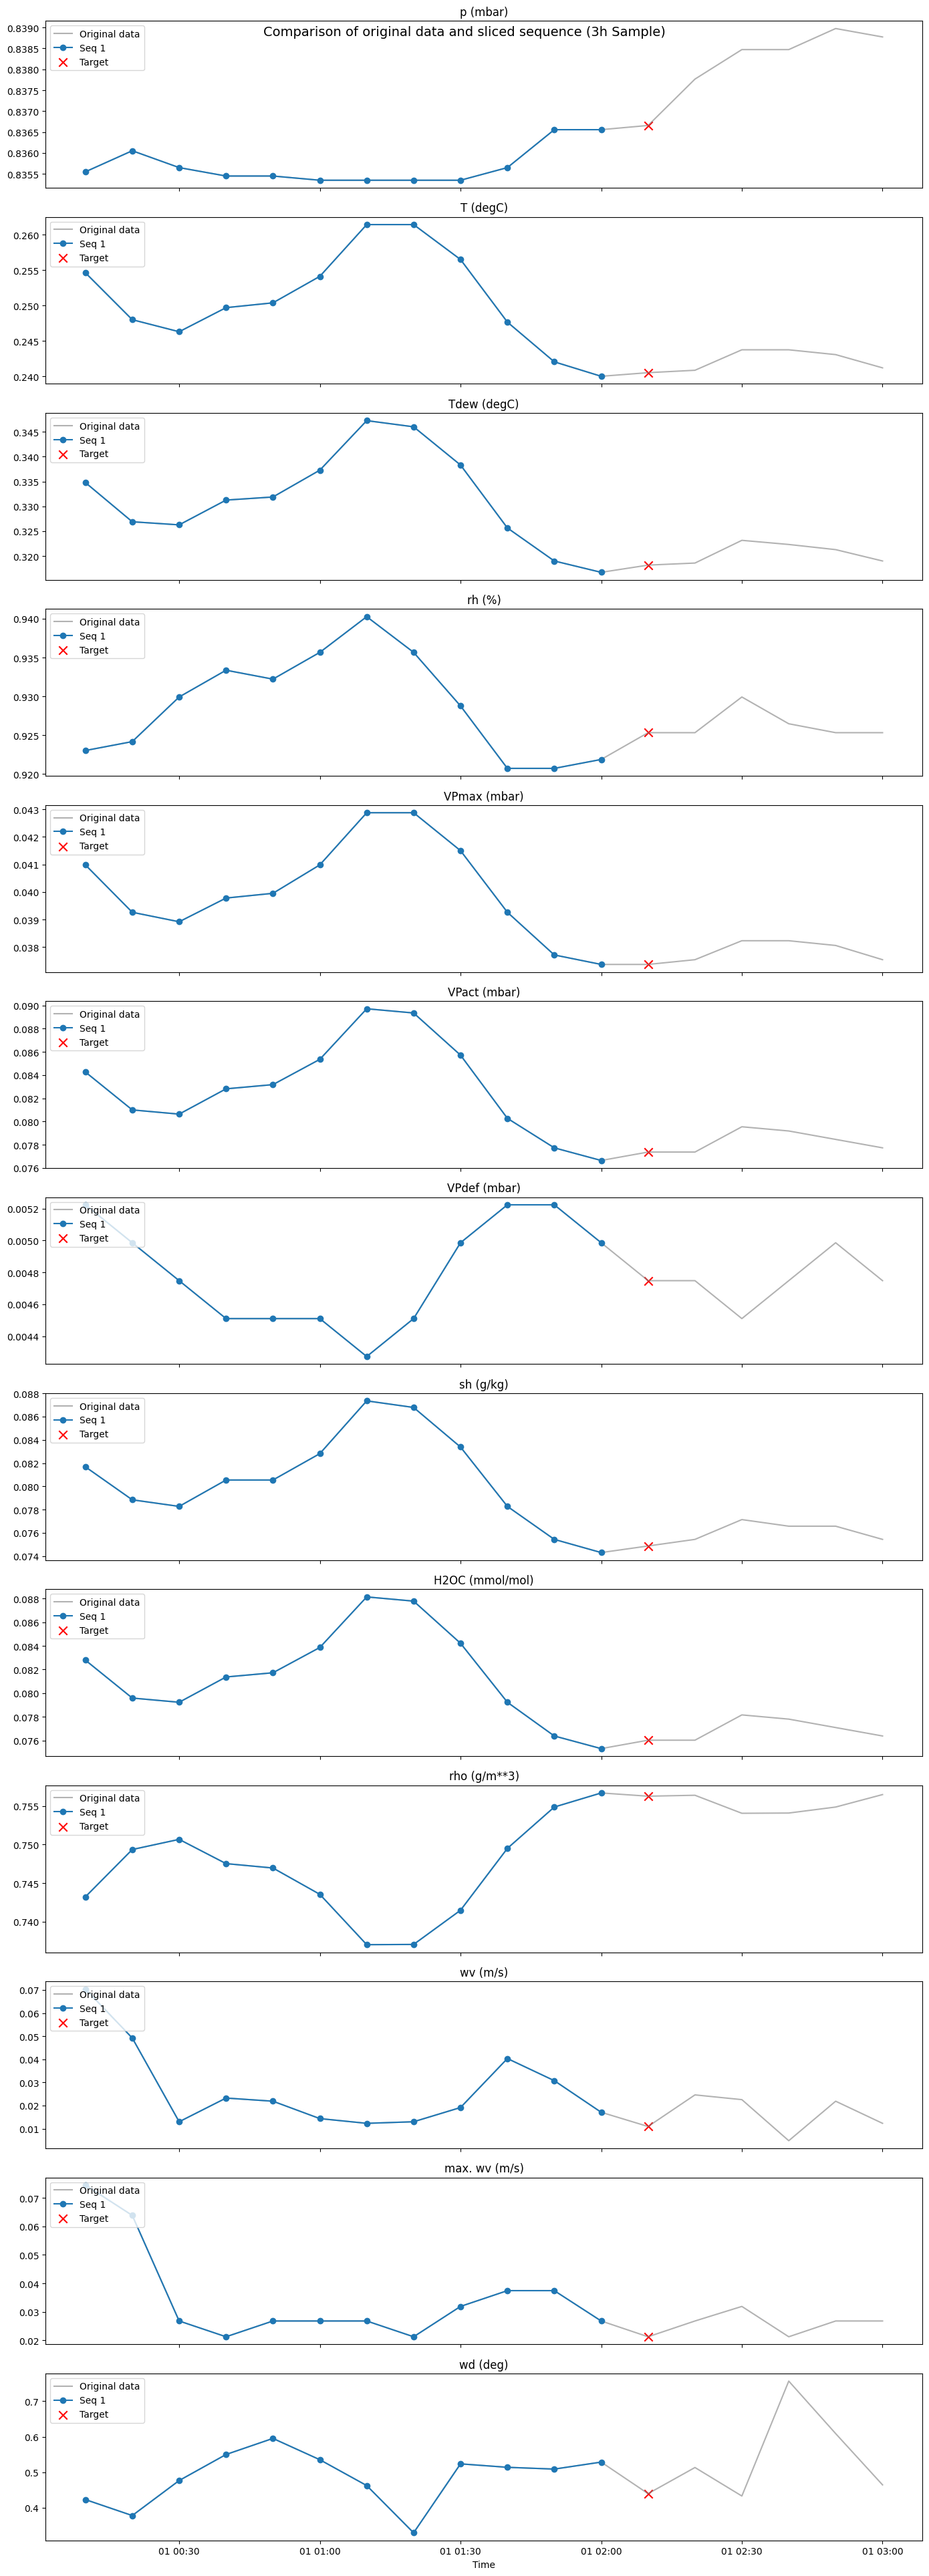

In [41]:
df = pd.read_csv("../data/train_set_normalized.csv")
df["Date Time"] = pd.to_datetime(df["Date Time"], format='%d.%m.%Y %H:%M:%S')

points_per_hour = 6
hours_to_plot = 3
subset = df.iloc[:hours_to_plot * points_per_hour]
timestamps_subset = subset["Date Time"].values
data_subset = subset[NUMERIC_COLS].values

sequence_length = X_train.shape[1]
forecast_horizon = y_train.shape[1]
X_subset, y_subset = create_sequences(data_subset, sequence_length, forecast_horizon)

num_sequences_to_plot = 1  # how many sample sequences to show
fig, axes = plt.subplots(len(NUMERIC_COLS), 1, figsize=(14, 3 * len(NUMERIC_COLS)), sharex=True)

for idx, col in enumerate(NUMERIC_COLS):
    ax = axes[idx] if len(NUMERIC_COLS) > 1 else axes

    # Original data (gray)
    ax.plot(subset["Date Time"], subset[col], color="gray", alpha=0.6, label="Original data")

    # Sequences
    for i in range(num_sequences_to_plot):
        seq_start = i
        seq_end = i + sequence_length
        seq_time = subset["Date Time"].iloc[seq_start:seq_end]

        ax.plot(seq_time, X_subset[i, :, idx], marker="o", label=f"Seq {i+1}")

        # The target (future point)
        target_time = subset["Date Time"].iloc[seq_end:seq_end+forecast_horizon]
        ax.scatter(target_time, y_subset[i, :, idx], color="red", marker="x", s=80, label="Target" if i == 0 else "")

    ax.set_title(col)
    ax.legend(loc="upper left")

plt.suptitle("Comparison of original data and sliced sequence (3h Sample)", fontsize=14)
plt.xlabel("Time")
plt.tight_layout()
plt.show()
